In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Imports

In [2]:
# TENSORFLOW #
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow_addons import image
import tensorflow_addons as tfa

# SKLEARN
from sklearn.model_selection import StratifiedKFold

# Other
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tabulate as tbl

In [3]:
# Load a dataset
(train, valid, test), metadata = tfds.load('cassava', # Plants
                              split = ['train', 'test', 'validation'],
                              as_supervised = True, # Get labels
                              shuffle_files=True, 
                              with_info = True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteVSYEV0/cassava-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteVSYEV0/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteVSYEV0/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [4]:
# Set sizes
train_size = metadata.splits['train'].num_examples
valid_size = metadata.splits['validation'].num_examples
test_size = metadata.splits['test'].num_examples

# Check details
print(f'Training set size: {train_size} | Validation set size: {valid_size} | Testing set size: {test_size}')

Training set size: 5656 | Validation set size: 1889 | Testing set size: 1885


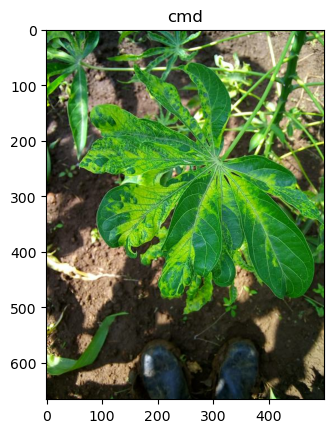

In [5]:
# Convert numbers into labels
get_label_name = metadata.features['label'].int2str

# Show an image
for image,label in train.take(1):
    # Plot the image
    plt.imshow(image)
    # Set the label as the title
    plt.title(get_label_name(label))

Before beginning the project, it's important to understand the distribution of at least the training set's labels, as it should be relatively similar in the validation and testing sets.

In [6]:
# Find the number of classes
num_classes = metadata.features['label'].num_classes
# Find the class labels
class_names = metadata.features["label"].names

# Check
print(f'There are {num_classes} classes in the Cassava dataset. The labels are: {class_names}.')

There are 5 classes in the Cassava dataset. The labels are: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy'].


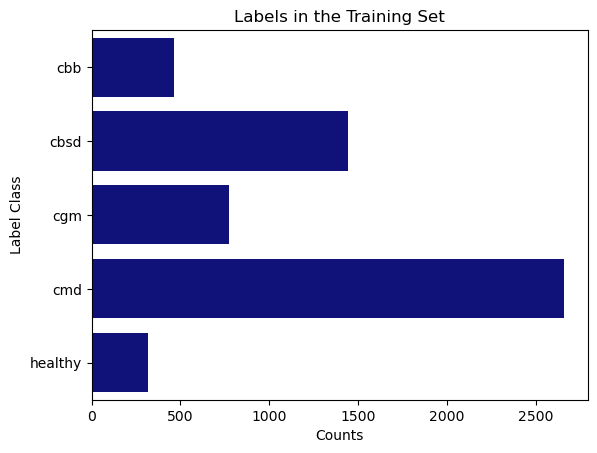

<Figure size 1200x1000 with 0 Axes>

In [7]:
# Hold the list of training labels
training_labels = []

# Access all the labels
for images, labels in train.take(-1):
    training_labels.append(get_label_name(labels.numpy()))
    
# Create a counter
label_counts = Counter(training_labels)

# Ordered keys
ordered_labels = sorted(label_counts.keys())

# Display breakdown of training labels
sns.barplot(x = [label_counts[k] for k in ordered_labels],
            y = ordered_labels,
            orient = 'h',
            color = 'darkblue')

# Titles
plt.xlabel('Counts')
plt.ylabel('Label Class')
plt.title('Labels in the Training Set')

# Show
plt.figure(figsize=(12,10))
plt.show()

The dataset is imbalanced, so when training the model, using cross-validation would be beneficial. However, some data augmentation should be done in addition to this.

In [8]:
# Image size
img_size = 224

# Normalize function
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_size, img_size])
    # Normalize
    image = (image / 255.0)
    return image, label

In [9]:
# Calculate rotation angles
angle_vals = np.array([5.0, 15.0, 25.0, 45.0, 120.0, 165.0, 250.0]) # Base angles

# Augmentation
def augmenter(image, label):
    # Normalize - call this first
    image, label = normalize(image, label)
    # Rotate
    rotation = (np.random.choice(angle_vals) * np.pi / 180.0).astype(np.float32)
    image = tfa.image.rotate(image, angles = rotation, interpolation = "NEAREST")
    # Brightness
    image = tf.image.random_brightness(image, 0.5)
    # Return image and label
    return image, label
    

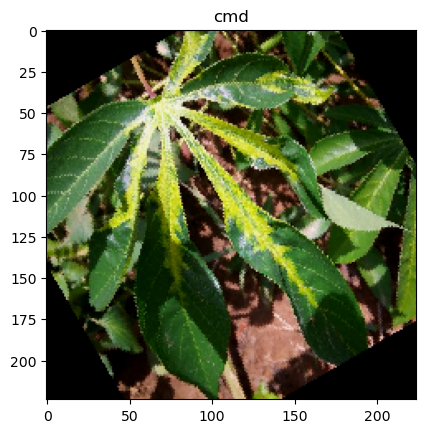

In [10]:
# Show an example of an augmented image
for image, label in train.take(1):
    img, lbl = augmenter(image, label)
    plt.imshow(img)
    plt.title(get_label_name(lbl))

### Create Data Pipelines

In [11]:
# Batch size
batch = 32

# Build the pipelines
num_training_examples = train_size // 100

# Training
training_batch = train.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

# Validation
validation_batch = valid.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

# Test
testing_batch = test.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

## Build a Basic Model

This will be a very simple sequential feed forward model. We will use the following layers:
 - Dense
 - Conv2D
 - MaxPooling2D
 - Flatten
 
 The order of layers matters: Conv2D > MaxPooling2D > Flatten > Dense.
 
 Between each layer, the size of the tensor has to be tracked.

In [12]:
# Create a sequential model
model = Sequential([Conv2D(16, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(32, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(64, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Flatten(), # Flatten
                    Dense(num_classes, activation = 'softmax')])

In [13]:
# Compile the model
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Model build
model.build((None, 224, 224, 3))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0